In [45]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skbio

from scipy import stats
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa   
from ete3 import Tree
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from skbio.stats.distance import anosim
from skbio.stats.distance import DistanceMatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.model_selection import train_test_split
from skbio.stats.composition import clr

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

# To send

1. alpha diversity: test results & plots
2. permanova results [optional]
3. PROCRUSTES results + Aitchinson distance
4. LMMs & Wilcoxon 

TESTS
1. ADONIS
2. KRUSKALL WALLIS ON ALPHA DIVERSITY
3. RANDOM FOREST WITH SHAP VALUES

In [2]:
relab_otu_df = pd.read_csv('data/lung_cancer_123_phylo_rare_otu.tsv', sep = '\t')
relab_sample_df = pd.read_csv('data/lung_cancer_123_phylo_rare_sample.tsv', sep = '\t')
relab_tax_df = pd.read_csv('data/lung_cancer_123_phylo_rare_tax.tsv', sep = '\t')

absolute_otu_df = pd.read_csv('data/lung_cancer_123_quant_otu.tsv', sep = '\t')
absolute_sample_df = pd.read_csv('data/lung_cancer_123_quant_sample.tsv', sep = '\t')
absolute_tax_df = pd.read_csv('data/lung_cancer_123_quant_tax.tsv', sep = '\t')

In [3]:
relab_otu_df.shape, absolute_otu_df.shape

((582, 96), (477, 69))

In [4]:
progression_dict = dict(zip(relab_sample_df.index, relab_sample_df['Progression.Yes.No']))
treatment_dict = dict(zip(relab_sample_df.index, relab_sample_df['Treatment']))
patient_dict = dict(zip(relab_sample_df.index, relab_sample_df['Patient']))

In [5]:
def get_patients_timepoints(metadata):
    
    'return patient id that have pre and post sample'
    
    patients_count = pd.DataFrame.\
                    from_dict(Counter(metadata.Patient), orient='index').\
                    reset_index().\
                    rename({"index":"patient", 0:"count"}, axis=1)
    
    keep_patients =  patients_count[patients_count['count'] == 2].patient.values
    keep_samples = metadata[metadata.Patient.isin(keep_patients)].index.values
    return keep_patients, keep_samples

relab_keep_patient, relab_keep_sample = get_patients_timepoints(relab_sample_df)
absolute_keep_patient, absolute_keep_sample = get_patients_timepoints(absolute_sample_df)

In [8]:
# Filter otu table 
relab_otu_df = relab_otu_df[relab_keep_sample]
relab_sample_df = relab_sample_df[relab_sample_df.index.isin(relab_keep_sample)] 

absolute_otu_df = absolute_otu_df[absolute_keep_sample]
absolute_sample_df = absolute_sample_df[absolute_sample_df.index.isin(absolute_keep_sample)] 

## Prepare data

In [9]:
#Collapse features on species level

def merge_on_species_level(df, tax_df):
    
    species_dict = dict(zip(tax_df.index, [specie.replace(' ', '_').replace(':', '_') for specie in tax_df.Species]))
    
    species_df = df.copy()
    species_df.index = species_df.index.map(species_dict)
    species_df = species_df.groupby(by = species_df.index).sum()
    
    return species_df

relab_species_df = merge_on_species_level(relab_otu_df, relab_tax_df)
absolute_species_df = merge_on_species_level(absolute_otu_df, absolute_tax_df)

In [10]:
relab_species_df.shape, absolute_species_df.shape

((473, 54), (416, 54))

## Filter low abundance data

In [11]:
def filter_prevalence(df, treshold = 0.1):
    '''features as columns'''
    df_binary = df.copy()
    df_binary[df_binary>0]=1
    df_binary_sum = df_binary.sum(axis=0)
    
    keep_features = df_binary_sum[df_binary_sum > df.shape[0]*treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

def filter_on_abundance(df, abundance_treshold = 0):
    '''features as columns'''
    df_relab = df.div(df.sum(axis=1), axis=0)
    df_relab_mean = df_relab.mean()

    keep_features = df_relab_mean[df_relab_mean > abundance_treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

filtered_relab_otu_df = filter_prevalence(relab_otu_df.T)
filtered_relab_species_df = filter_prevalence(relab_species_df.T)

filtered_absolute_otu_df = filter_prevalence(absolute_otu_df.T)
filtered_absolute_species_df = filter_prevalence(absolute_species_df.T)

In [12]:
filtered_relab_species_df.shape, filtered_absolute_species_df.shape

((54, 391), (54, 378))

In [13]:
# Prepare tree for phylogenetic analysis
def prepare_tree(tree_file, df, name):
    
    ete3_tree = Tree(tree_file, format=1)
    
    otu_ids = df.columns.tolist()
    ete3_tree.prune(otu_ids, True)
    ete3_tree.write(format=1, outfile=f"data/{name}_prunned_tree.nwk")
    
    # red into skbio 
    tree = skbio.TreeNode.read(f'data/{name}_prunned_tree.nwk')
    return tree

In [14]:
relab_tree = prepare_tree('data/lung_cancer_123_phylo_rare_tree.nwk', filtered_relab_otu_df, 'relab')
absolute_tree = prepare_tree('data/lung_cancer_123_quant_tree.nwk', filtered_absolute_otu_df, 'absolute')

## 1. 1. alpha diversity between datawith Kruskal Wallis and Wilcoxon tests

In [15]:
from skbio.diversity.alpha import faith_pd, shannon, chao1, pielou_e

In [16]:
def calculate_alpha_diversities(species_df, features_df, tree):
    
    shannon_df = species_df.apply(lambda x: shannon(x),axis=1)
    faith_pd_df = features_df.apply(lambda x: faith_pd(x, taxa = features_df.columns, tree=tree),axis=1)
    chao_df = species_df.apply(lambda x: chao1(x),axis=1)
    pielou_df = species_df.apply(lambda x: pielou_e(x),axis=1)
    
    alpha_diversity_df = pd.concat([shannon_df, faith_pd_df, chao_df, pielou_df], axis=1)
    alpha_diversity_df.columns = ['shannon', 'faith', 'chao', 'pielou']
    
    alpha_diversity_df['Progression'] = alpha_diversity_df.index.map(progression_dict)
    alpha_diversity_df['Treatment'] = alpha_diversity_df.index.map(treatment_dict)
    alpha_diversity_df['Patient'] = alpha_diversity_df.index.map(patient_dict)

    return alpha_diversity_df

In [17]:
relative_alpha_diversity = calculate_alpha_diversities(filtered_relab_species_df, filtered_relab_otu_df, relab_tree)
absolute_alpha_diversity = calculate_alpha_diversities(filtered_absolute_species_df, filtered_absolute_otu_df, absolute_tree)

In [18]:
Conditions1 = ['Yes', 'No']
Conditions2 = ['Pre', 'Post']

results = []
for cond1 in Conditions1:
    for cond2 in Conditions2:

        df1 = relative_alpha_diversity[(relative_alpha_diversity.Progression == cond1) & (relative_alpha_diversity.Treatment == cond2)]
        df2 = absolute_alpha_diversity[(absolute_alpha_diversity.Progression == cond1) & (absolute_alpha_diversity.Treatment == cond2)]
        
        diversity_metrics = ['shannon', 'faith', 'chao', 'pielou']
        
        for div in diversity_metrics:
            
            results.append({"cond1":cond1,
                            "cond2":cond2,
                            "measure":div,
                            "pvalue":stats.mannwhitneyu(df1[div], df2[div])[1]})

In [19]:
results_df = pd.DataFrame(results)
results_df['pvalue_adj'] = np.where(results_df.pvalue < 0.05, 1, 0)
results_df

,cond1,cond2,measure,pvalue,pvalue_adj
0,Yes,Pre,shannon,0.007661,1
1,Yes,Pre,faith,0.681618,0
2,Yes,Pre,chao,0.456894,0
3,Yes,Pre,pielou,0.010344,1
4,Yes,Post,shannon,0.504985,0
5,Yes,Post,faith,1.000000,0
6,Yes,Post,chao,0.877440,0
7,Yes,Post,pielou,0.383320,0
8,No,Pre,shannon,0.015854,1
9,No,Pre,faith,0.597223,0


In [250]:
results_df.to_csv('outputs/alpha_diversities_Mann_test.csv')

In [20]:
for div in diversity_metrics:
    print(div, np.round(stats.mannwhitneyu(relative_alpha_diversity[div], absolute_alpha_diversity[div])[1], 3))

shannon 0.001
faith 0.756
chao 0.513
pielou 0.001


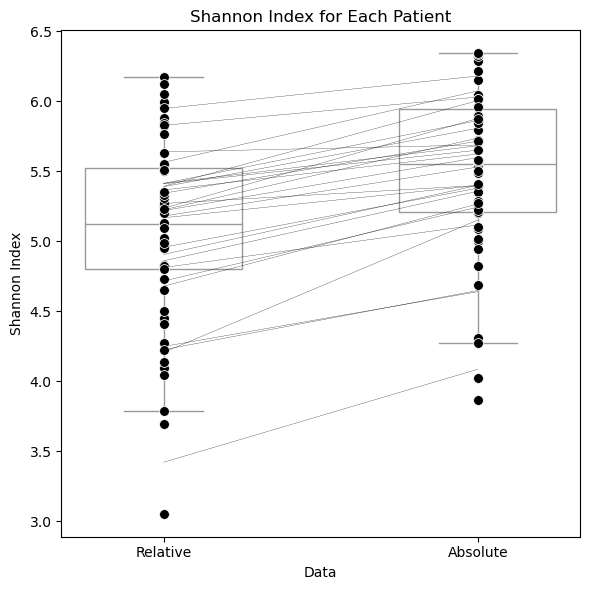

In [247]:
x1 = relative_alpha_diversity[['Patient', 'shannon']]
x1['data'] = 'Relative'

x2 = absolute_alpha_diversity[['Patient', 'shannon']]
x2['data'] = 'Absolute'

x3 = pd.concat([x1, x2])

plt.figure(figsize=(6, 6))

# Draw the boxplot first
sns.boxplot(data=x3, x='data', y='shannon', color='white', zorder=1, width=.5)

# Draw the scatter plot and line plot for each patient
for patient in x3.Patient.unique():
    patient_data = x3[x3['Patient'] == patient]
    sns.scatterplot(data=patient_data, x='data', y='shannon', color='k', zorder=2, s=50)
    sns.lineplot(data=patient_data, x='data', y='shannon', color='k', lw=0.2, err_style=None, zorder=3)

# Customize the plot
plt.title("Shannon Index for Each Patient")
plt.xlabel("Data")
plt.ylabel("Shannon Index")

plt.tight_layout()
plt.savefig('outputs/shannon.png', dpi=300)
# Show the plot
plt.show()

In [285]:
relative_alpha_diversity.to_csv('outputs/alpha_diversity/relative_alpha_diversity.csv')
absolute_alpha_diversity.to_csv('outputs/alpha_diversity/absolute_alpha_diversity.csv')

In [ ]:
# plot a scatterlot of alpha diversity; boxplot with lines between patients 

# PROCRUSTES

In [254]:
def calculate_WU(df, taxa, tree):
    
    num_samples = df.shape[0]
    unifrac_matrix = np.zeros((num_samples, num_samples))
    
    for i in range(num_samples):
        for j in range(i, num_samples):  # Start from i to compute only the upper triangle
            if i == j:
                unifrac_matrix[i, j] = 0  # Distance from a sample to itself is zero
            else:
                distance = weighted_unifrac(df.iloc[i], df.iloc[j], taxa=taxa, tree=tree)
                unifrac_matrix[i, j] = distance
                unifrac_matrix[j, i] = distance  # Symmetric matrix
    
    return unifrac_matrix

def calculate_UWU(df, taxa, tree):
    num_samples = df.shape[0]
    unifrac_matrix = np.zeros((num_samples, num_samples))
    
    for i in range(num_samples):
        for j in range(i, num_samples):  # Start from i to compute only the upper triangle
            if i == j:
                unifrac_matrix[i, j] = 0  # Distance from a sample to itself is zero
            else:
                distance = unweighted_unifrac(df.iloc[i], df.iloc[j], taxa=taxa, tree=tree)
                unifrac_matrix[i, j] = distance
                unifrac_matrix[j, i] = distance  # Symmetric matrix
    
    return unifrac_matrix

In [255]:
def calculate_pcoa(species_input, otu_input, tree):
    
    #species_input = filtered_relab_species_df.copy()
    #otu_input = filtered_relab_otu_df.copy()

    WU_M = calculate_WU(otu_input, otu_input.columns, tree)

    logE_M = squareform(pdist(np.log(species_input+1e-2)))
    BC_M = squareform(pdist(species_input,'braycurtis'))
    Aitchinson_M = squareform(pdist(clr(species_input+1),'euclidean'))

    binary_species = species_input.copy()
    binary_species[binary_species>0]=1
    J_M = squareform(pdist(binary_species,'jaccard'))

    binary_otu = otu_input.copy()
    binary_otu[binary_otu>0]=1
    UWU_M = calculate_UWU(binary_otu, binary_otu.columns, tree)

    return pcoa(WU_M).samples, pcoa(logE_M).samples, pcoa(BC_M).samples, pcoa(UWU_M).samples, pcoa(J_M).samples, pcoa(Aitchinson_M).samples

In [256]:
pcoaWU_rel, pcoaE_rel, pcoaBC_rel, pcoaUWU_rel, pcoaJ_rel, pcoaA_rel = calculate_pcoa(filtered_relab_species_df, filtered_relab_otu_df, relab_tree)
pcoaWU_abs, pcoaE_abs, pcoaBC_abs, pcoaUWU_abs, pcoaJ_abs, pcoaA_abs = calculate_pcoa(filtered_absolute_species_df, filtered_absolute_otu_df, absolute_tree)

In [257]:
from scipy.spatial import procrustes

WU1, WU2, WUdisp = procrustes(pcoaWU_rel, pcoaWU_abs)
UWU1, UWU2, UWUdisp = procrustes(pcoaUWU_rel, pcoaUWU_abs)
E1, E2, Edisp = procrustes(pcoaE_rel, pcoaE_abs)
BC1, BC2, BCdisp = procrustes(pcoaBC_rel, pcoaBC_abs)
J1, J2, Jdisp = procrustes(pcoaJ_rel, pcoaJ_abs)
A1, A2, Adisp = procrustes(pcoaA_rel, pcoaA_abs)

d = [WUdisp, UWUdisp, Edisp, BCdisp, Jdisp, Adisp]
measures = ['WU', 'UWU', 'Euclidean', 'BC', 'Jaccard', 'Aitchinson']
disparity_df = pd.DataFrame(list(zip(measures, d)), columns = ['distance', 'disparity'])
disparity_df.to_csv('outputs/disparity.csv')

In [265]:
pd.DataFrame(WU1, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/WU1.csv')
pd.DataFrame(WU2, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/WU2.csv')

pd.DataFrame(UWU1, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/UWU1.csv')
pd.DataFrame(UWU2, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/UWU2.csv')

pd.DataFrame(E1, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/E1.csv')
pd.DataFrame(E2, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/E2.csv')

pd.DataFrame(BC1, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/BC1.csv')
pd.DataFrame(BC2, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/BC2.csv')

pd.DataFrame(J1, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/J1.csv')
pd.DataFrame(J2, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/J2.csv')

pd.DataFrame(A1, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/A1.csv')
pd.DataFrame(A2, columns=filtered_relab_species_df.index, index=filtered_relab_species_df.index).to_csv('outputs/A2.csv')

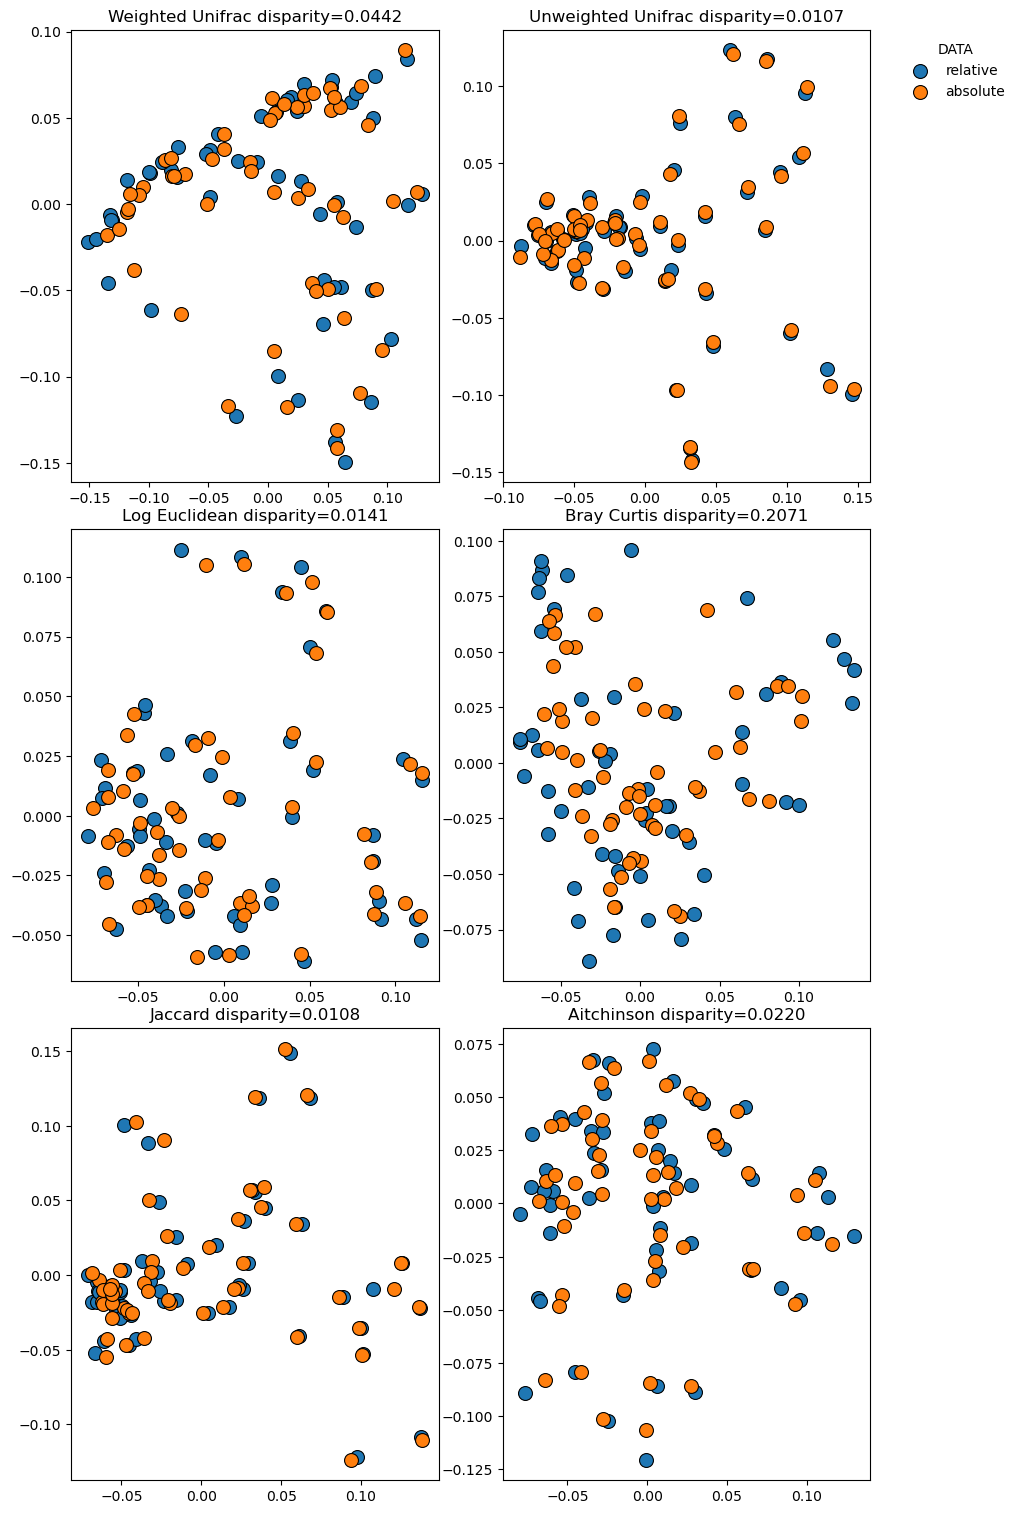

In [32]:
fig, axes = plt.subplots(3, 2, figsize = (10, 15))

sns.scatterplot(x = WU1[:, 0], y = WU1[:, 1], ax=axes[0, 0], s=100, edgecolor='k')
sns.scatterplot(x = WU2[:, 0], y = WU2[:, 1], ax=axes[0, 0], s=100, edgecolor='k')

sns.scatterplot(x = UWU1[:, 0], y = UWU1[:, 1], ax=axes[0, 1], label = 'relative', s=100, edgecolor='k')
sns.scatterplot(x = UWU2[:, 0], y = UWU2[:, 1], ax=axes[0, 1], label = 'absolute', s=100, edgecolor='k')

sns.scatterplot(x = E1[:, 0], y = E1[:, 1], ax=axes[1, 0], s=100, edgecolor='k')
sns.scatterplot(x = E2[:, 0], y = E2[:, 1], ax=axes[1, 0], s=100, edgecolor='k')

sns.scatterplot(x = BC1[:, 0], y = BC1[:, 1], ax=axes[1, 1], s=100, edgecolor='k')
sns.scatterplot(x = BC2[:, 0], y = BC2[:, 1], ax=axes[1, 1], s=100, edgecolor='k')

sns.scatterplot(x = J1[:, 0], y = J1[:, 1], ax=axes[2, 0], s=100, edgecolor='k')
sns.scatterplot(x = J2[:, 0], y = J2[:, 1], ax=axes[2, 0], s=100, edgecolor='k')

sns.scatterplot(x = A1[:, 0], y = A1[:, 1], ax=axes[2, 1], s=100, edgecolor='k')
sns.scatterplot(x = A2[:, 0], y = A2[:, 1], ax=axes[2, 1], s=100, edgecolor='k')

axes[0, 0].title.set_text(f'Weighted Unifrac disparity={WUdisp:.4f}')
axes[0, 1].title.set_text(f'Unweighted Unifrac disparity={UWUdisp:.4f}')
axes[1, 0].title.set_text(f'Log Euclidean disparity={Edisp:.4f}')
axes[1, 1].title.set_text(f'Bray Curtis disparity={BCdisp:.4f}')
axes[2, 0].title.set_text(f'Jaccard disparity={Jdisp:.4f}')
axes[2, 1].title.set_text(f'Aitchinson disparity={Adisp:.4f}')

axes[0, 1].legend(bbox_to_anchor = (1.4, 1), edgecolor='w', title='DATA')

plt.tight_layout(pad = .2)
plt.savefig('procrustes.png', dpi=300)

# LMMs

In [172]:
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial import distance

In [114]:
def run_LMMs(input_data, data_type):
    
    # rename columns 
    renamed_df = input_data.copy()
    renamed_df.columns = [f'col{i}' for i in range(len(renamed_df.columns))]
    
    cols_dict = dict(zip(renamed_df.columns, filtered_relab_species_df.columns))
    
    # join with metadata
    LMMS_INPUT_DF = pd.merge(renamed_df, relab_sample_df[['Patient', 'Treatment', 'Progression.Yes.No']], left_index=True, right_index=True)
    LMMS_INPUT_DF = LMMS_INPUT_DF[LMMS_INPUT_DF['Treatment'] == 'Pre']
    LMMS_INPUT_DF['outcome'] = np.where(LMMS_INPUT_DF['Progression.Yes.No'] == 'Yes', 1, 0)
    
    # Run LMMs
    lmm_results = []
    for bacteria in renamed_df.columns:
        try:
        
            formula = f"{bacteria} ~ outcome"
            
            model = smf.mixedlm(formula, LMMS_INPUT_DF, groups=LMMS_INPUT_DF["Patient"])
            model_fit = model.fit()
            
            pvalue = model_fit.pvalues.get(f'outcome')
            coeff = model_fit.params.get(f'outcome')
        
            lmm_results.append({
                'bacteria': bacteria,
                'coeff': coeff,
                'pvalue': pvalue})
        except: 
            lmm_results.append({
                    'bacteria': bacteria,
                    'coeff': None,
                    'pvalue': None})
    
    lmm_results_df = pd.DataFrame(lmm_results)
    lmm_results_df['bacteria'] = lmm_results_df.bacteria.map(cols_dict)
    
    lmm_results_df['pvalues_adj'] = statsmodels.stats.multitest.multipletests(lmm_results_df['pvalue'].fillna(1), alpha=0.05, method='fdr_bh')[1]
    lmm_results_df['significant'] = np.where(lmm_results_df.pvalues_adj < 0.05, 1, 0)
    lmm_results_df[lmm_results_df['significant'] == 1]
    lmm_results_df['data'] = data_type

    return lmm_results_df

In [115]:
absolute_lmm_results = run_LMMs(filtered_absolute_species_df, 'Absolute')
relative_lmm_results = run_LMMs(filtered_relab_species_df, 'Relative')

In [131]:
absolute_lmm_results = absolute_lmm_results.rename({'pvalue': 'abs_pvalue'}, axis=1)
relative_lmm_results = relative_lmm_results.rename({'pvalue': 'rel_pvalue'}, axis=1)

In [189]:
X = pd.concat([relative_lmm_results[['bacteria', 'rel_pvalue']], absolute_lmm_results[['bacteria', 'abs_pvalue']]], axis=0).fillna(1)
Euclidean_distances = [np.linalg.norm(X.rel_pvalue.iloc[i]-X.abs_pvalue.iloc[i]) for i in range(len(X))]
X['dist'] = Euclidean_distances

X = np.round(X.sort_values(by = 'dist'), 4)
X.to_csv('LMMs_results.csv')
X

,bacteria,rel_pvalue,abs_pvalue,dist
324,s__Ruminococcus_torques_CAG_61,1.0,1.0000,0.0000
145,s__Collinsella_intestinalis,1.0,1.0000,0.0000
179,s__Erysipelatoclostridium_ramosum,1.0,1.0000,0.0000
374,s__[Clostridium]_leptum,1.0,0.9982,0.0018
69,s__Bacteroides_uniformis,1.0,0.9982,0.0018
...,...,...,...,...
114,s__Citrobacter_freundii,0.0,1.0000,1.0000
37,s__Atlantibacter_hermannii,0.0,1.0000,1.0000
207,s__Firmicutes_bacterium_CAG_272_52_7,1.0,0.0000,1.0000
327,s__Sanguibacteroides_justesenii,0.0,1.0000,1.0000


# Wilcoxon test

In [183]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

def run_Wilcoxon(input_data, data_type):
    # Rename columns 
    renamed_df = input_data.copy()
    renamed_df.columns = [f'col{i}' for i in range(len(renamed_df.columns))]

    # Map the original column names to the renamed ones for clarity
    cols_dict = dict(zip(renamed_df.columns, input_data.columns))

    # Join with metadata
    LMMS_INPUT_DF = pd.merge(
        renamed_df,
        relab_sample_df[['Patient', 'Treatment', 'Progression.Yes.No']],
        left_index=True,
        right_index=True
    )
    
    # Filter for pre-treatment data
    LMMS_INPUT_DF = LMMS_INPUT_DF[LMMS_INPUT_DF['Treatment'] == 'Pre']

    # Create outcome variable
    LMMS_INPUT_DF['outcome'] = np.where(LMMS_INPUT_DF['Progression.Yes.No'] == 'Yes', 1, 0)

    # Run Wilcoxon tests
    wilcoxon_results = []

    for bacteria in renamed_df.columns:
        try:
            # Select data for "Yes" and "No" outcomes
            yes_data = LMMS_INPUT_DF[LMMS_INPUT_DF['outcome'] == 1][bacteria]
            no_data = LMMS_INPUT_DF[LMMS_INPUT_DF['outcome'] == 0][bacteria]

            # Check if the lengths are the same (paired test) or use min length for slicing
            min_length = min(len(yes_data), len(no_data))
            
            # Wilcoxon signed-rank test
            stat, pvalue = wilcoxon(
                yes_data[:min_length],
                no_data[:min_length],
                alternative='two-sided'
            )
            
            # Calculate median difference as an effect size (can also use mean if preferred)
            coeff = np.median(yes_data) - np.median(no_data)
        
            wilcoxon_results.append({
                'bacteria': bacteria,
                'coeff': coeff,
                'pvalue': pvalue
            })
        
        except Exception as e:
            # Handle exceptions gracefully
            wilcoxon_results.append({
                'bacteria': bacteria,
                'coeff': None,
                'pvalue': None
            })
            print(f"Exception for {bacteria}: {e}")

    # Create a DataFrame for results
    wilcoxon_results_df = pd.DataFrame(wilcoxon_results)
    
    # Map original column names back to results for readability
    wilcoxon_results_df['bacteria'] = wilcoxon_results_df['bacteria'].map(cols_dict)

    # Adjust p-values for multiple comparisons using BH method
    wilcoxon_results_df['pvalues_adj'] = multipletests(
        wilcoxon_results_df['pvalue'].fillna(1),
        alpha=0.05,
        method='fdr_bh'
    )[1]

    # Mark significant results
    wilcoxon_results_df['significant'] = np.where(
        wilcoxon_results_df['pvalues_adj'] < 0.05, 1, 0
    )

    # Filter for significant results if needed
    significant_results = wilcoxon_results_df[wilcoxon_results_df['significant'] == 1]

    # Add data type for context
    wilcoxon_results_df['data'] = data_type

    return wilcoxon_results_df

In [184]:
absolute_wilcoxon_results = run_Wilcoxon(filtered_absolute_species_df, 'Absolute')
relative_wilcoxon_results = run_Wilcoxon(filtered_relab_species_df, 'Relative')

absolute_wilcoxon_results = absolute_wilcoxon_results.rename({'pvalue': 'abs_pvalue'}, axis=1)
relative_wilcoxon_results = relative_wilcoxon_results.rename({'pvalue': 'rel_pvalue'}, axis=1)

In [187]:
X = pd.concat([relative_wilcoxon_results[['bacteria', 'rel_pvalue']], absolute_wilcoxon_results[['bacteria', 'abs_pvalue']]], axis=0).fillna(1)
Euclidean_distances = [np.linalg.norm(X.rel_pvalue.iloc[i]-X.abs_pvalue.iloc[i]) for i in range(len(X))]
X['dist'] = Euclidean_distances

X = np.round(X.sort_values(by = 'dist'), 4)
X.to_csv('Wilcoxon_results.csv')

In [188]:
X

,bacteria,rel_pvalue,abs_pvalue,dist
7,s__Actinomyces_odontolyticus,1.0000,1.0000,0.0000
220,s__Holdemanella_biformis,1.0000,1.0000,0.0000
241,s__Lachnospiraceae_bacterium_A2,1.0000,1.0000,0.0000
307,s__Ruminococcus_champanellensis,1.0000,1.0000,0.0000
299,s__Roseburia_hominis,1.0000,1.0000,0.0000
...,...,...,...,...
354,s__[Clostridium]_asparagiforme,1.0000,0.0081,0.9919
16,s__Akkermansia_sp._KLE1605,0.0061,1.0000,0.9939
18,s__Akkermansia_sp._KLE1798,0.0046,1.0000,0.9954
17,s__Akkermansia_sp._KLE1797,0.0046,1.0000,0.9954
